<a href="https://colab.research.google.com/github/aldisstar/Taller-MIT/blob/main/Feature_Engineering_Kobe_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

## Introduction

In machine learning, we want to construct a model that takes in input data and outputs a prediction. Data comes in the form of **data points** and **features**.

A **datapoint** is a single example of data. For example, if we are predicting  whether or not it will rain based on the temperature, a datapoint might be x=10 and our label is y=True. Meaning that on some day it was 10 degrees and it rained. A **feature** is an individual property of a datapoint. Our data has 1 feature, temperature. We could add more features, such as the forecast which might be a piece of text such as "Cloudy", "Sunny", etc. Now our datapoints have two elements, such as x = [10, "Cloudy"].

Our models however, need the input to be numbers, so we must process our data. That's where feature engineering comes in!

![feat eng pic](https://developers.google.com/machine-learning/crash-course/images/RawDataToFeatureVector.svg)

In lecture we discussed these types of data:
1. **Numerical - Continuous** - a number quantity, such as Temperature.
2.  **Numerical - Discrete** - quantities that come in fixed values, such as integers. An example is number of people.
3. **Categorical - Nominal** - fixed number of different possible values, such as "Cloudy", "Sunny", "Rainy" forecasts.
4. **Categorical - Ordinal** - similar to categorical, there is a fixed number of possible values, but there is an ordered relationship, such as a size feature with options "Low", "Medium", "High".
5. **Text** - any possible series of characters.

We will discuss different types of data and how they are processed in order to properly model their relationships.

### Step 1 Imports and Setup

We will be working with some data from Kaggle - a machine learning competition site with many datasets: https://www.kaggle.com/competitions/kobe-bryant-shot-selection/discussion/20888

The dataset here contains a record of the shots that Kobe Bryant took throughout his Basketball Career, and which ones he made. The purpose of the dataset is to determine how to predict whether or not Kobe will make a shot



In [ ]:

# ==============================================
# 1. Module imports
# ==============================================

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# scaling
from sklearn.preprocessing import StandardScaler

# classification algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import train_test_split

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay


# text mining
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

###Step 2 Explore the dataset

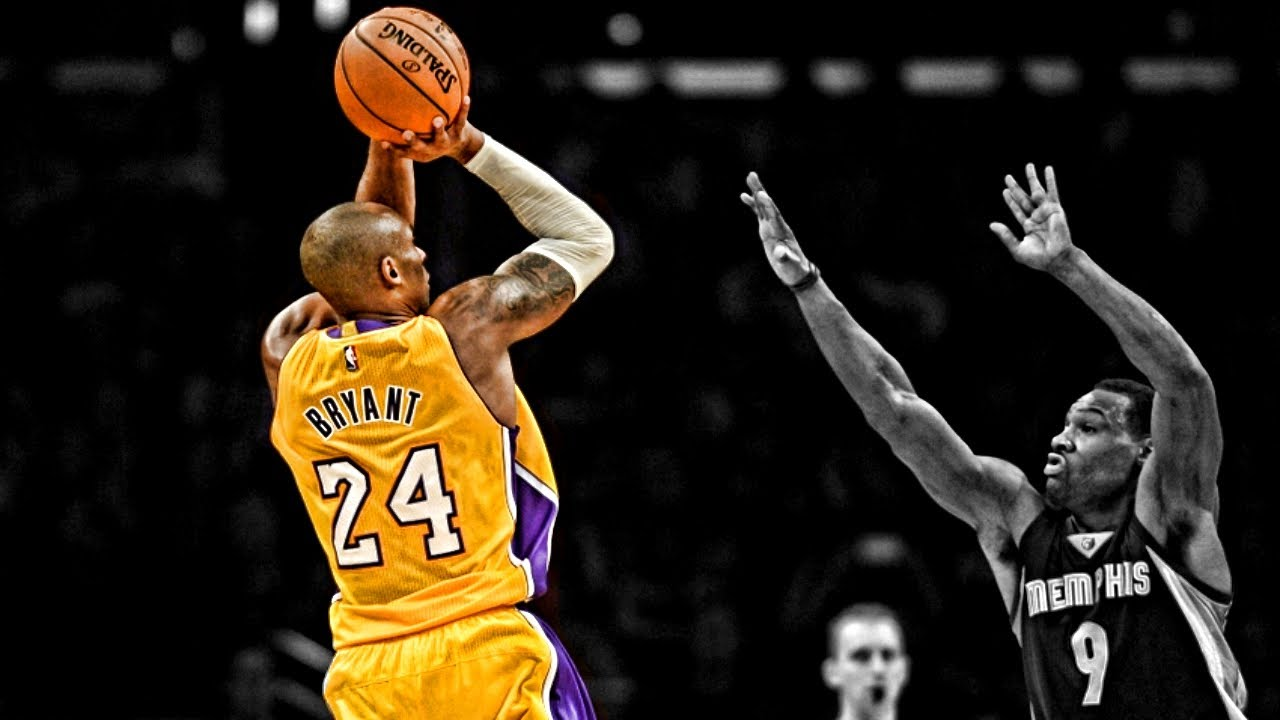

In this lesson, we will be looking at data concerning Kobe Bryant's basketball record. ![Screenshot 2024-01-09 at 11.04.23 AM.png](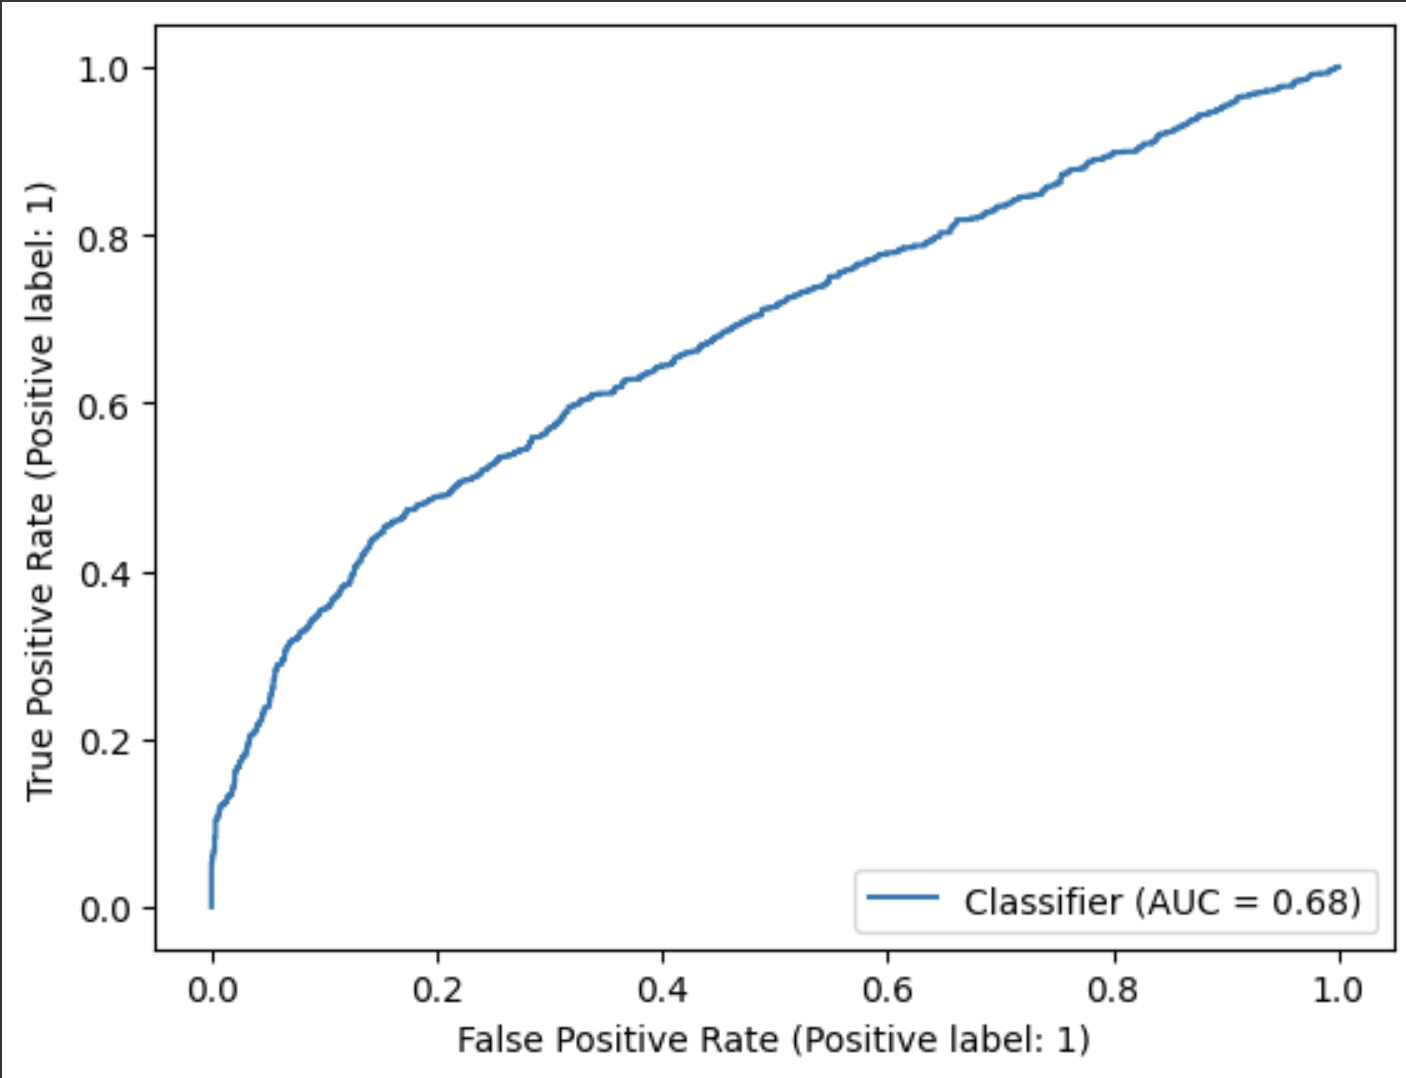![instructor_roc.png](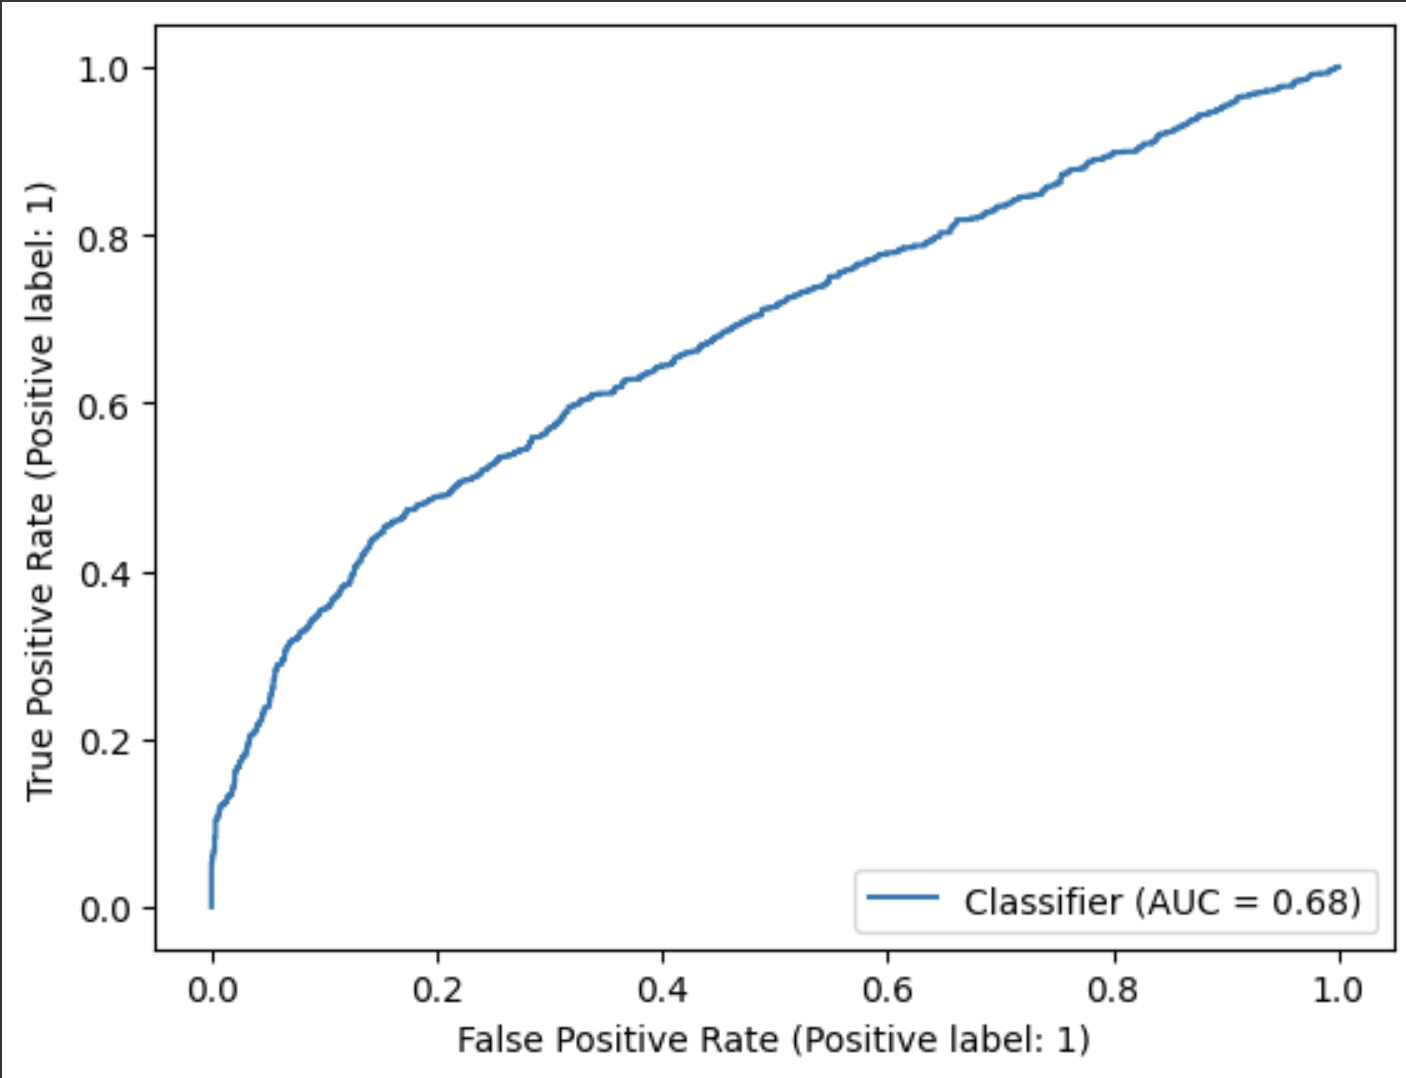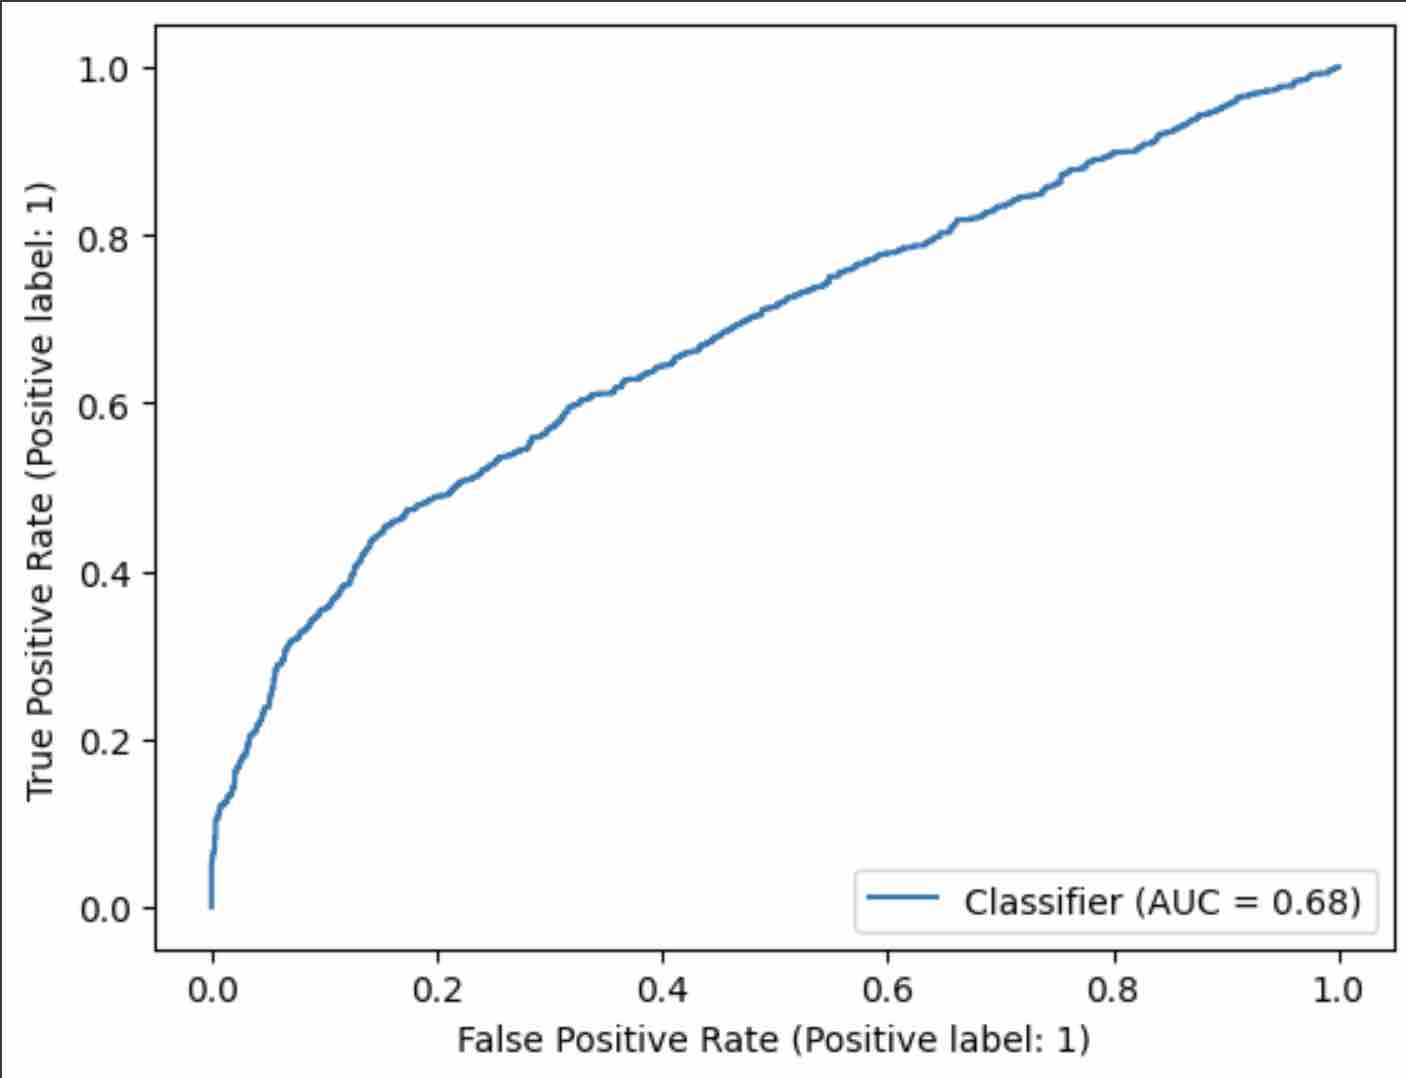))In the last lesson we stored our data in a np array. We will now load our data into a pandas dataframe which also stores the data as a table.
Each row of the table is a datapoint and each column represents a feature. We can check the shape of the data to see how many datapoints and features we have.

Note, there are a lot of features in this dataset, but we will mostly focus on these ones:



1. **action_type** - the type of shot that Kobe took (Jump shot, Driving Layup Shot, etc)
2. **loc_x** - the x coordinate of the shot (side-to-side), where 0 is the middle of the court
3. **loc_y** - The y coordinate of the shot (up & down the court), where 0 is the free throw line
4. **shot_distance** - the shot's distance, in feet, from the basket
5. **shot_zone_basic** - level area of the court the shot was taken from (top level)
6. **shot_zone_area** - the area of the court the shot was taken from (lower level)
7. **shot_type** - "2PT Field Goal" or "3PT Field Goal"
8. **period** - the period of the game, including overtime
9. **minutes_remaining** - the number of minutes remaining in the period, within the period
10. **seconds_remaining** - the number of seconds, within the minutes, within the period, remaining in the period
11. **playoffs** - binary variable indicating whether or not the game was a playoff game
12. **season** - which season the game was played in
13. **game_date**
14. **matchup** - Los Angeles Lakers (LAL) @ or vs. Opponent Team. An "@" symbol indicates an away game, while "vs." indicates a home game.
15. **shot_made_flag** - our dependent variable, did Kobe make the shot (1 = he did)

Note, this dataset does *not* give shots in chronological order. Be sure not to use future data to predict the present (hint)






In [ ]:
# load the data as a pandas dataframe
#Get CSV File from here: https://drive.google.com/file/d/1HTNFCuuwnqpzg5zxPXjIl6Z2pFZ8W7p1/view?usp=share_link
#Upload CSV File into files tab on lefthand toolbar, then proceed with:
KobeDataset = pd.read_csv('Kobe data.csv')
print("Data dimensions:" + str(KobeDataset.shape))

# we will narrow our focus to only the 15 features listed above
KobeDataset = KobeDataset.filter(["action_type", "loc_x", "loc_y","shot_distance", "shot_zone_basic", "shot_zone_area", "shot_type",
                                  "period", "minutes_remaining", "seconds_remaining", "playoffs", "season", "game_date","matchup", "shot_made_flag"])

print("Filtered Data dimensions:" + str(KobeDataset.shape))

display(KobeDataset.head(10))

Data dimensions:(30697, 31)
Filtered Data dimensions:(30697, 15)


,action_type,loc_x,loc_y,shot_distance,shot_zone_basic,shot_zone_area,shot_type,period,minutes_remaining,seconds_remaining,playoffs,season,game_date,matchup,shot_made_flag
0,Jump Shot,167,72,18.0,Mid-Range,Right Side(R),2PT Field Goal,1,10,27,0,2000-01,10/31/00,LAL @ POR,NaN
1,Jump Shot,-157,0,15.0,Mid-Range,Left Side(L),2PT Field Goal,1,10,22,0,2000-01,10/31/00,LAL @ POR,0.0
2,Jump Shot,-101,135,16.0,Mid-Range,Left Side Center(LC),2PT Field Goal,1,7,45,0,2000-01,10/31/00,LAL @ POR,1.0
3,Jump Shot,138,175,22.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,6,52,0,2000-01,10/31/00,LAL @ POR,0.0
4,Driving Dunk Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,2,6,19,0,2000-01,10/31/00,LAL @ POR,1.0
5,Jump Shot,-145,-11,14.0,Mid-Range,Left Side(L),2PT Field Goal,3,9,32,0,2000-01,10/31/00,LAL @ POR,0.0
6,Layup Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,3,8,52,0,2000-01,10/31/00,LAL @ POR,1.0
7,Jump Shot,1,28,2.0,Restricted Area,Center(C),2PT Field Goal,3,8,5,0,2000-01,10/31/00,LAL @ POR,NaN
8,Jump Shot,-65,108,12.0,In The Paint (Non-RA),Left Side(L),2PT Field Goal,3,6,12,0,2000-01,10/31/00,LAL @ POR,1.0
9,Running Jump Shot,-33,125,12.0,In The Paint (Non-RA),Center(C),2PT Field Goal,3,3,36,0,2000-01,10/31/00,LAL @ POR,0.0


In [ ]:
#Next, lets check for missing data
#Missing data in this dataset is represented by nan values (as opposed to blanks, "?", etc)
#This is good, because it is pandas' expectation

KobeDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   action_type        30697 non-null  object 
 1   loc_x              30697 non-null  int64  
 2   loc_y              30697 non-null  int64  
 3   shot_distance      30696 non-null  float64
 4   shot_zone_basic    30697 non-null  object 
 5   shot_zone_area     30697 non-null  object 
 6   shot_type          30697 non-null  object 
 7   period             30697 non-null  int64  
 8   minutes_remaining  30697 non-null  int64  
 9   seconds_remaining  30697 non-null  int64  
 10  playoffs           30697 non-null  int64  
 11  season             30697 non-null  object 
 12  game_date          30697 non-null  object 
 13  matchup            30697 non-null  object 
 14  shot_made_flag     25697 non-null  float64
dtypes: float64(2), int64(6), object(7)
memory usage: 3.5+ MB






Unfortunately, we have exactly 5000 nulls in our dependent variable (**shot_made_flag**).
As a data scientist, whenever you see such a round number for anything, you should be suspicious!
Why would the dataset be missing EXACTLY 5000 values?

In this case, these values were removed for the purposes of competition on Kaggle.com, to be evaluated as the competitors' test set.
Since this is our dependent variable, we don't have much choice but to remove the 5000 records.


**Exercise 1:**
* Please remove the **5000** records with missing values for **shot_made_flag**
* Deal with the **1** missing record for **shot_distance** however you see fit! (some possibilities would be to mean the value, back-calculate it from loc_x & loc_y, drop it, etc.)

In [ ]:
FullLength = len(KobeDataset)

KobeDataset = KobeDataset.dropna() # Dropping the nan for simplicity
NewLength = len(KobeDataset)

print("Removed", FullLength - NewLength, "records")

Removed 5001 records


# Step 3 - Data Visualization
Before we train our model, let's take a peek at the variable distributions to get a feel for which variables we expect will be the most relevant to our task at hand (predicting whether or not shots will go in).

For now we focus on numerical features. For numerical features we don't have categories that we can use as the x-axis. But we can split the datapoints into bins, such as 0.0 to 0.1 and look at the number of 0 and 1 labels for that bin.

Here we use the [pandas.cut()](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) method to bin our variables before we visualize with pandas crosstab. Two very helpful tools!

<Axes: xlabel='seconds_remaining'>

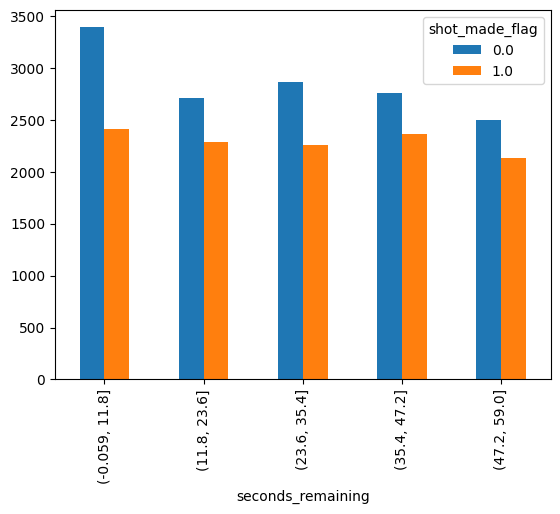

In [ ]:
# For numerical variables, we can bin the amounts and check frequency of labels within each bin
pd.crosstab(pd.cut(KobeDataset["seconds_remaining"], bins= 5), KobeDataset['shot_made_flag']).plot(kind= "bar")

**Exercise 2** Now you, please make plots for the following variables:
1. shot_distance
2. Any other *numerical* variable of your choosing

Looking at the plots, which feature do you think will be more useful for making predictions about the label (seconds_remaining, shot_distance, your chosen variable)? Why?

'\n  Question: Looking at the plots, which feature do you think will be more useful\n  for making predictions about the label (seconds_remaining, shot_distance,\n  your chosen variable)? Why do you think so?\n\n  Answer:\n'

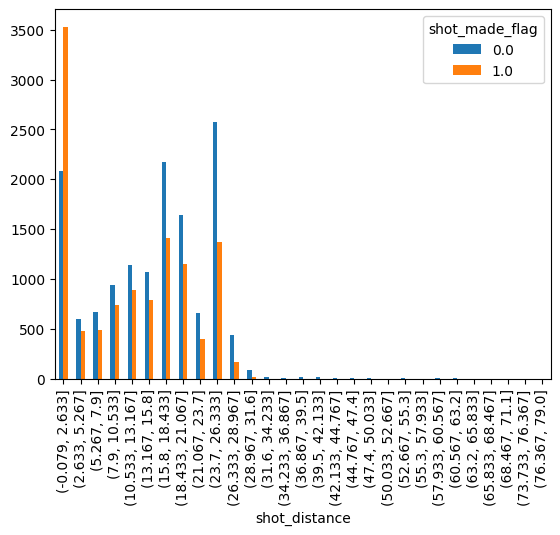

In [ ]:
pd.crosstab(pd.cut(KobeDataset["shot_distance"], bins= 30), KobeDataset['shot_made_flag']).plot(kind= "bar")

"""
  Question: Looking at the plots, which feature do you think will be more useful
  for making predictions about the label (seconds_remaining, shot_distance,
  your chosen variable)? Why do you think so?

  Answer:
"""

In [ ]:
print('mean ', KobeDataset.mean(axis = 0))
print('standard deviation', KobeDataset.std(axis = 0))

mean  loc_x                 7.148739
loc_y                91.254826
shot_distance        13.457036
period                2.520859
minutes_remaining     4.886947
seconds_remaining    28.311683
playoffs              0.146248
shot_made_flag        0.446139
dtype: float64
standard deviation loc_x                110.075277
loc_y                 88.152896
shot_distance          9.388903
period                 1.151609
minutes_remaining      3.452457
seconds_remaining     17.523721
playoffs               0.353362
shot_made_flag         0.497100
dtype: float64


## Step 4 - Baseline Model


As seen before, we will divide the data into three groups for training, validation and ultimately testing. Today we will only work with the train and test sets, but you will see validation sets and their importance later.

**Exercise 3:** Using the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method please separate KobeDataset with a 10:90 test train split. Specify a random state if you'd like to make your runs replicable.

In [ ]:
# =============================
# Test-train split
# =============================

Kobe_train, Kobe_test = None, None
Kobe_train, Kobe_test = train_test_split(KobeDataset, test_size= 0.1, train_size= 0.9, random_state= 234)

print("Train data size: " + str(Kobe_train.shape))
print("Test data size: " + str(Kobe_test.shape))

Train data size: (23126, 15)
Test data size: (2570, 15)


Our first model will only use numerical features that don't require encoding. If you're wondering which are these numerical features, tadaa!


In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print('These are the numerical features! \n', Kobe_train.select_dtypes(include=numerics).columns.to_list())

These are the numerical features! 
 ['loc_x', 'loc_y', 'shot_distance', 'period', 'minutes_remaining', 'seconds_remaining', 'playoffs', 'shot_made_flag']


**Exercise 4:**
* From the set of numerical features shown above, select 2-3 which you believe will be the most relevant for predicting shot_made (**this is ofc not including shot_made_flag**). Populate the list `Kobe_feat` with your selected features

* Create a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model. Fit said model to predict `Kobe_train["shot_made_flag"]` from `Kobe_train[Kobe_feat]`.

In [ ]:
# ==========================================
# Baseline Model
# ==========================================

Kobe_feat = [None, None, None]
Kobe_model = None

Kobe_feat = [
    "shot_distance",
    "loc_x",
    "loc_y",
  ]
#Fit the model
Kobe_model = LogisticRegression()
## Recall, the dependent variable (y) is "shot made flag"
Kobe_model.fit(Kobe_train[Kobe_feat], Kobe_train["shot_made_flag"])


LogisticRegression()

We'll begin evaluating our baseline model by examining a **confusion matrix**  

A **confusion matrix** is a table with 4 different combinations of predicted and actual values. Here is a confusion matrix in picture form. On the left, we see a confusion matrix and on the right we see an explanation of TP, FP, FN, TN.

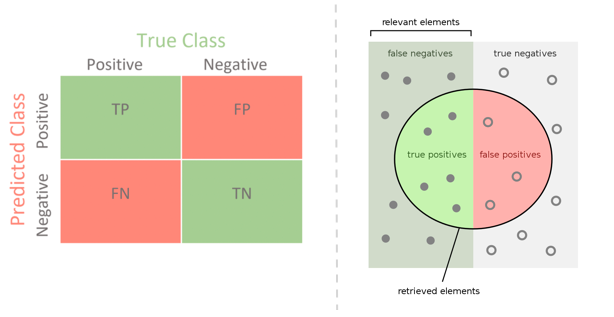

**Optional Exercise**: We have prefilled the threshold value to be 0.445, feel free to change this value & play around with it. How does changing the threshold impact the TPR & TNR? Why?

In [ ]:
# predict on test data
Kobe_predictions = Kobe_model.predict_proba(Kobe_test[Kobe_feat])
# predict_proba() returns probabilities for each of Kobe_model.classes_
# we are concerned only with the results for class 1.0 which is the second index
# so we narrow to Kobe_predictions[:,1]
print('before we narrow to the second index', Kobe_predictions.shape)
Kobe_predictions = Kobe_predictions[:,1]
print('after we narrow to the second index', Kobe_predictions.shape)
print("Prediction Examples: ", Kobe_predictions[:5], "\n")

#set a threshold over which we predict a successful shot
threshold = .445
Kobe_Binary_Predictions = Kobe_predictions>threshold
print("Binary Prediction Examples: ", Kobe_Binary_Predictions[:5], "\n")

tp, fn, fp, tn = confusion_matrix(Kobe_test["shot_made_flag"], Kobe_Binary_Predictions, labels = [1,0], normalize = 'all').flatten()

print("{0:.1%}".format(tp), "of the time we predicted Kobe would make it, and he did")
print("{0:.1%}".format(fn), "of the time we predicted Kobe would NOT make it, and he did")
print("{0:.1%}".format(fp), "of the time we predicted Kobe would make it, and he did NOT")
print("{0:.1%}".format(tn), "of the time we predicted Kobe would NOT make it, and he did NOT")


before we narrow to the second index (2570, 2)
after we narrow to the second index (2570,)
Prediction Examples:  [0.31365135 0.42116921 0.59498953 0.33781464 0.37333105] 

Binary Prediction Examples:  [False False  True False False] 

23.1% of the time we predicted Kobe would make it, and he did
21.6% of the time we predicted Kobe would NOT make it, and he did
20.7% of the time we predicted Kobe would make it, and he did NOT
34.6% of the time we predicted Kobe would NOT make it, and he did NOT


In [ ]:

def evaluate_logistic_regression(dataset, feat, DepVar, threshold=0.445):
  train, test = train_test_split(dataset, test_size= 0.1, train_size= 0.9, random_state= 234)
  train = train[feat + [DepVar]].dropna() # Filter out any missing values

  model = LogisticRegression().fit(train[feat], train[DepVar])

  predictions = model.predict_proba(test[feat])
  predictions = predictions[:,1]
  binary_predictions = predictions>threshold

  display(
      RocCurveDisplay.from_predictions(test[DepVar], predictions)
  )

  return roc_auc_score(test[DepVar], predictions), model, binary_predictions, test

In [ ]:
#We can then calculate some other metrics with these results
#Reference: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

#True positive Rate, or Sensitivity - tells us the portion of the successful shots that were correctly classified
TPR = tp / (tp + fn)
print("TPR is ", "{0:.1%}".format(TPR))

FNR = fn / (tp + fn)
print("FNR is ", "{0:.1%}".format(FNR))

#True Negative Rate, or specificity - tells us what proportion of the missed shots were correctly classified
TNR = tn / (tn + fp)
print("TNR is ", "{0:.1%}".format(TNR))

#False Positive Rate, or 1 - Specificity - tells us the portion of the missed shots incorrectly classified
FPR = fp / (tn + fp)
print("FPR is ", "{0:.1%}".format(FPR))


TPR is  51.6%
FNR is  48.4%
TNR is  62.6%
FPR is  37.4%


In [ ]:
#Let's try our new evaluation metrics defined this morning:

FutureShotPct = tp / (tp + fp)
print("If Kobe follows our algorithm, he could make ","{0:.1%}".format(FutureShotPct),
      " of the shots he takes, ", tp, " shots made.")

FutureOppoShotPct = fn / (fn + tn)
print("If Kobe follows our algorithm, he could have made ","{0:.1%}".format(FutureOppoShotPct),
      " of the shots he didn't take, ", fn, " shots would have been made.")

If Kobe follows our algorithm, he could make  52.8%  of the shots he takes,  0.23073929961089495  shots made.
If Kobe follows our algorithm, he could have made  38.5%  of the shots he didn't take,  0.21634241245136188  shots would have been made.


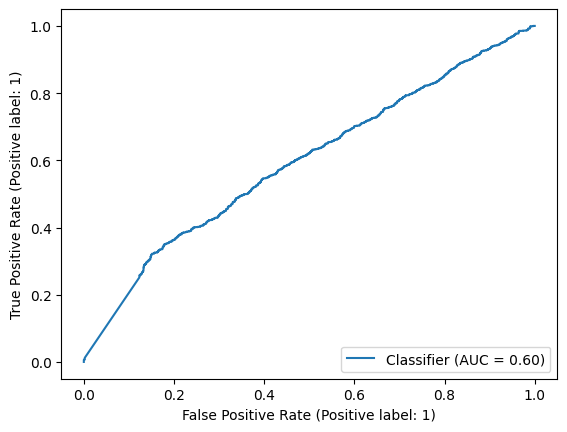

In [ ]:
#Finally, the ROC Curve plots TPR at FPR at various threshold values,
#so that we can evaluate the model without having to specify a threshold manually

display(
    RocCurveDisplay.from_predictions(Kobe_test["shot_made_flag"], Kobe_predictions)
)

A good ROC Curve would have points where the TPR is high, but the FPR is still low, in the top left quadrant of the graph, like pictured below. Did your model get close to this?

A bad model, on the other hand, results in a straight, diagonal line. This represents a perfect tradeoff between TPR & FPR driven by the threshold value alone. In other words, the model added no value in distinguishing between made shots & missed shots, and we're better off randomly guessing :(

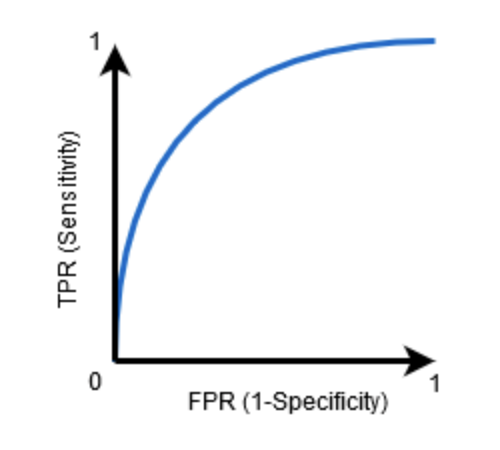

In [ ]:
# Thus, we can score our models, independently of the threshold value, by calculating the area under the curve, or AUC. A diagonal line would result in an AUC of 50%
# While a perfect prediction results in an AUC of 100%. Where does your model fall?

# auc score
print("Baseline logistic regression performance: ", "{0:.0%}".format(roc_auc_score(Kobe_test["shot_made_flag"], Kobe_predictions)))

Baseline logistic regression performance:  60%


In [ ]:
# For future exercises, we will define a function to take in a dataset and a feature list
# and evaluate the model on it.

def evaluate_logistic_regression(dataset, feat, DepVar, threshold=0.445):
  train, test = train_test_split(dataset, test_size= 0.1, train_size= 0.9, random_state= 234)
  train = train[feat + [DepVar]].dropna()

  model = LogisticRegression().fit(train[feat], train[DepVar])

  predictions = model.predict_proba(test[feat])
  predictions = predictions[:,1]
  binary_predictions = predictions>threshold

  display(
      RocCurveDisplay.from_predictions(test[DepVar], predictions)
  )

  return roc_auc_score(test[DepVar], predictions), model, binary_predictions, test

## Step 5 - Categorical Data

Representing categorical data is typical done by making **one-hot features**. We make a new feature for each category. Then for a datapoint, if it belongs to category k, then we make that column 1 and all other category columns 0.

We will practice this with the "shot_zone_basic" feature. But first let's take a closer look at the shot_zone_basic variable and how it breaks down by shot_made...

In [ ]:
# Frequency table for how many datapoints have a specific category and label
pd.crosstab(KobeDataset["shot_zone_basic"], KobeDataset["shot_made_flag"])

shot_made_flag,0.0,1.0
shot_zone_basic,,
Above the Break 3,3166,1554
Backcourt,59,1
In The Paint (Non-RA),2117,1763
Left Corner 3,151,89
Mid-Range,6253,4278
Restricted Area,2266,3666
Right Corner 3,220,113


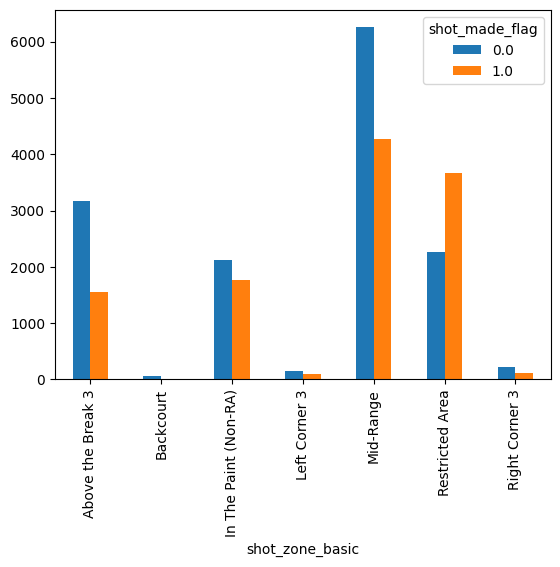

In [ ]:
# a plot of the table above
pd.crosstab(KobeDataset['shot_zone_basic'], KobeDataset['shot_made_flag']).plot(kind="bar");

Now let's create a one hot column to encode the shot_zone

In [ ]:
# We'll now create a one-hot column for each category using the function pd.get_dummies -
# Reference documentation: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

shot_zones = pd.get_dummies(KobeDataset["shot_zone_basic"], prefix= "shot_zone")
shot_zones.head(5)

,shot_zone_Above the Break 3,shot_zone_Backcourt,shot_zone_In The Paint (Non-RA),shot_zone_Left Corner 3,shot_zone_Mid-Range,shot_zone_Restricted Area,shot_zone_Right Corner 3
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0
5,0,0,0,0,1,0,0


Notice how each datapoint has one column with a 1 in it and the rest are zeros.

**Exercise 5** What shot zones are datapoint 979, 1084, 25? (**Hint** the method [iloc[ ]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) might be useful here!)

In [ ]:
##delete or comment out "break"
# break
print(shot_zones.iloc[979])
print(shot_zones.iloc[1084])
print(shot_zones.iloc[25])
# Answer: 979: In The Paint, 1084: Restricted Range, 25: In The Paint

shot_zone_Above the Break 3        0
shot_zone_Backcourt                0
shot_zone_In The Paint (Non-RA)    1
shot_zone_Left Corner 3            0
shot_zone_Mid-Range                0
shot_zone_Restricted Area          0
shot_zone_Right Corner 3           0
Name: 1178, dtype: uint8
shot_zone_Above the Break 3        0
shot_zone_Backcourt                0
shot_zone_In The Paint (Non-RA)    0
shot_zone_Left Corner 3            0
shot_zone_Mid-Range                0
shot_zone_Restricted Area          1
shot_zone_Right Corner 3           0
Name: 1295, dtype: uint8
shot_zone_Above the Break 3        0
shot_zone_Backcourt                0
shot_zone_In The Paint (Non-RA)    1
shot_zone_Left Corner 3            0
shot_zone_Mid-Range                0
shot_zone_Restricted Area          0
shot_zone_Right Corner 3           0
Name: 29, dtype: uint8


Now we will combine these one-hot columns with the whole dataset.

In [ ]:
KobeDataset = KobeDataset.join(shot_zones)
KobeDataset.shape

(25696, 22)

**Exercise 6** How many extra columns did we create for this one-hot encoding?

Finally, let's see how these new features affect our baseline model performance.



In [ ]:
list(KobeDataset.columns)

['action_type',
 'loc_x',
 'loc_y',
 'shot_distance',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_type',
 'period',
 'minutes_remaining',
 'seconds_remaining',
 'playoffs',
 'season',
 'game_date',
 'matchup',
 'shot_made_flag',
 'shot_zone_Above the Break 3',
 'shot_zone_Backcourt',
 'shot_zone_In The Paint (Non-RA)',
 'shot_zone_Left Corner 3',
 'shot_zone_Mid-Range',
 'shot_zone_Restricted Area',
 'shot_zone_Right Corner 3']

0.5971180765454647

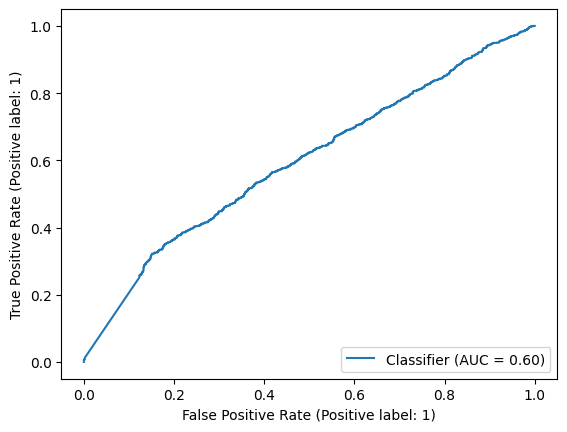

In [ ]:
feat = ["shot_distance", "loc_x", "loc_y", 'shot_zone_Above the Break 3', 'shot_zone_Backcourt', 'shot_zone_In The Paint (Non-RA)',
        'shot_zone_Left Corner 3','shot_zone_Mid-Range', 'shot_zone_Restricted Area', 'shot_zone_Right Corner 3']

evaluate_logistic_regression(KobeDataset, feat, "shot_made_flag")[0]



**Exercise 7** Did adding these features help? What does the fact that a model with more features can perform worse or no better than a model with fewer features tell us about feature selection?


## Step 8 - Other Encodings
**Exercise 8:** Now, we have some work to do! There are lots of other features we can use, but we'll need to be creative about how to encode some of them. Work with your teams to come up with more features to create, then create them!

The goal here is to flex your creativity, rather than your pandas abilities. Ask the instructors for help formulating your columns in pandas if needed!

As a challenge, the instructors were able to get ROC of ~0.68 w/ 71.9%  FutureShotPct & 35.7% FutureOppoShotPct

![](https://drive.google.com/uc?export=view&id=1fjhcOdKxM-IHtPpZQi3S7UGNl0kroLCF)

How high can you get your performance?

In [ ]:
# Perhaps you want to try other one hot encodings of the other categorical variables?

In [ ]:
#action_type

print(np.unique(np.concatenate(np.array(KobeDataset['action_type'].str.split(' ')))))
print(KobeDataset['action_type'].unique())

KobeDataset['Alley Oop'] = KobeDataset['action_type'].str.contains('Alley Oop').astype(int)

KobeDataset['Bank'] = KobeDataset['action_type'].str.contains('Bank').astype(int)

KobeDataset['Cutting'] = KobeDataset['action_type'].str.contains('Cutting').astype(int)

KobeDataset['Driving'] = KobeDataset['action_type'].str.contains('Driving').astype(int)

KobeDataset['Dunk'] = KobeDataset['action_type'].str.contains('Dunk').astype(int)

KobeDataset['Fadeaway'] = KobeDataset['action_type'].str.contains('Fadeaway').astype(int)

KobeDataset['Finger'] = KobeDataset['action_type'].str.contains('Finger').astype(int)

KobeDataset['Floating'] = KobeDataset['action_type'].str.contains('Floating').astype(int)

KobeDataset['Hook'] = KobeDataset['action_type'].str.contains('Hook').astype(int)

KobeDataset['Jump'] = KobeDataset['action_type'].str.contains('Jump').astype(int)

KobeDataset['Layup'] = KobeDataset['action_type'].str.contains('Layup').astype(int)

KobeDataset['Pull-Up'] = KobeDataset['action_type'].str.contains('Pull-Up').astype(int) + KobeDataset['action_type'].str.contains('Pullup').astype(int)

KobeDataset['Putback'] = KobeDataset['action_type'].str.contains('Putback').astype(int)

KobeDataset['Reverse'] = KobeDataset['action_type'].str.contains('Reverse').astype(int)

KobeDataset['Running'] = KobeDataset['action_type'].str.contains('Running').astype(int)

KobeDataset['Slam'] = KobeDataset['action_type'].str.contains('Slam').astype(int)

KobeDataset['Step'] = KobeDataset['action_type'].str.contains('Step').astype(int)

KobeDataset['Tip'] = KobeDataset['action_type'].str.contains('Tip').astype(int)

KobeDataset['Turnaround'] = KobeDataset['action_type'].str.contains('Turnaround').astype(int)

KobeDataset.head()


['Alley' 'Back' 'Bank' 'Cutting' 'Driving' 'Dunk' 'Fadeaway' 'Finger'
 'Floating' 'Follow' 'Hook' 'Jump' 'Layup' 'Oop' 'Pull-Up' 'Pullup'
 'Putback' 'Reverse' 'Roll' 'Running' 'Shot' 'Slam' 'Step' 'Tip'
 'Turnaround' 'Up' 'shot']
['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Drivin

,action_type,loc_x,loc_y,shot_distance,shot_zone_basic,shot_zone_area,shot_type,period,minutes_remaining,seconds_remaining,...,Jump,Layup,Pull-Up,Putback,Reverse,Running,Slam,Step,Tip,Turnaround
1,Jump Shot,-157,0,15.0,Mid-Range,Left Side(L),2PT Field Goal,1,10,22,...,1,0,0,0,0,0,0,0,0,0
2,Jump Shot,-101,135,16.0,Mid-Range,Left Side Center(LC),2PT Field Goal,1,7,45,...,1,0,0,0,0,0,0,0,0,0
3,Jump Shot,138,175,22.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,6,52,...,1,0,0,0,0,0,0,0,0,0
4,Driving Dunk Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,2,6,19,...,0,0,0,0,0,0,0,0,0,0
5,Jump Shot,-145,-11,14.0,Mid-Range,Left Side(L),2PT Field Goal,3,9,32,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#minutes & seconds left in period
KobeDataset['Seconds_left_in_Period'] = KobeDataset['minutes_remaining']*60 + KobeDataset['seconds_remaining']

In [ ]:
#total_time
print(KobeDataset.shape)
KobeDataset['RT'] = 4
KobeDataset['0'] = 0
KobeDataset['OT'] = KobeDataset['period'] - 4
KobeDataset['OT'] = np.max(KobeDataset[['OT','0']],axis=1)
KobeDataset['total_seconds'] = np.min(KobeDataset[['period', 'RT']]*12*60, axis = 1) + KobeDataset['OT']*5*60 - KobeDataset['Seconds_left_in_Period']
KobeDataset = KobeDataset.drop(['RT', 'OT','0'], axis = 1)
print(KobeDataset.shape)

(25696, 42)
(25696, 43)


In [ ]:
#period - set all OT to 5
KobeDataset['OT'] = 5
KobeDataset['regular_period'] = np.min(KobeDataset[['period', 'OT']], axis = 1)
KobeDataset = KobeDataset.drop('OT', axis = 1)

In [ ]:
#points
KobeDataset['3_Point_Shot'] = KobeDataset['shot_type'].str.contains('3').astype(int)
KobeDataset['points'] = KobeDataset['shot_type'].str.slice(0,1).astype(int)

#home v away
KobeDataset['home_game'] = KobeDataset['matchup'].str.contains('vs.').astype(int)


In [ ]:
#Season
KobeDataset['seasons'] = KobeDataset['season'].str.slice(0,4).astype(int)
KobeDataset['seasons'] = KobeDataset['seasons'] - min(KobeDataset['seasons'])
#KobeDataset[['season','seasons']].head()

#divisional opponent
KobeDataset['divisional_opponent'] = KobeDataset['matchup'].str.contains('PHX').astype(int) + KobeDataset['matchup'].str.contains('LAC').astype(int) + KobeDataset['matchup'].str.contains('SAC').astype(int) + KobeDataset['matchup'].str.contains('GSW').astype(int)


In [ ]:
#Now set the order
KobeDataset = KobeDataset.sort_values(['game_date','total_seconds'], ascending = True).reset_index(drop = True)#[['game_date', 'total_seconds']]

#assumes one game per day, which is true per excel
KobeDataset['ordered_gameday_id'] = KobeDataset.apply(lambda x: len(KobeDataset.loc[KobeDataset['game_date']<=x['game_date'], 'game_date'].unique()), axis = 1)


In [ ]:
#shots data this game
KobeDataset['points_today'] = KobeDataset.apply(lambda x: np.sum(KobeDataset.loc[(KobeDataset['ordered_gameday_id']==x['ordered_gameday_id']) & (KobeDataset['total_seconds']<x['total_seconds']), ['points', 'shot_made_flag']].prod(axis=1), axis = 0), axis = 1)
KobeDataset['shots_today'] = KobeDataset.apply(lambda x: len(KobeDataset.loc[(KobeDataset['ordered_gameday_id']==x['ordered_gameday_id']) & (KobeDataset['total_seconds']<x['total_seconds']),  'shot_made_flag']), axis = 1)
KobeDataset['points_per_shot_today'] = KobeDataset['points_today'] / KobeDataset['shots_today']
KobeDataset['points_per_shot_today'] = KobeDataset['points_per_shot_today'].fillna(-1) #first shot of the day will have -1
KobeDataset['points_per_sec_today'] = KobeDataset['points_today'] / KobeDataset['total_seconds']

In [ ]:
##shots data last game
KobeDataset['points_lastgame'] = KobeDataset.apply(lambda x: np.sum(KobeDataset.loc[(KobeDataset['ordered_gameday_id']==(x['ordered_gameday_id']-1)) , ['points', 'shot_made_flag']].prod(axis=1), axis = 0), axis = 1)
KobeDataset['shots_lastgame'] = KobeDataset.apply(lambda x: len(KobeDataset.loc[(KobeDataset['ordered_gameday_id']==(x['ordered_gameday_id']-1)),  'shot_made_flag']), axis = 1)
KobeDataset['points_per_shot_lastgame'] = KobeDataset['points_lastgame'] / KobeDataset['shots_lastgame']
KobeDataset['points_per_shot_lastgame'] = KobeDataset['points_per_shot_lastgame'].fillna(0)

##shots data prev 3 games
KobeDataset['points_prev3'] = KobeDataset.apply(lambda x: np.sum(KobeDataset.loc[(KobeDataset['ordered_gameday_id']<x['ordered_gameday_id']) & (KobeDataset['ordered_gameday_id']>=(x['ordered_gameday_id']-3)), ['points', 'shot_made_flag']].prod(axis=1), axis = 0), axis = 1)
KobeDataset['shots_prev3'] = KobeDataset.apply(lambda x: len(KobeDataset.loc[(KobeDataset['ordered_gameday_id']<x['ordered_gameday_id']) & (KobeDataset['ordered_gameday_id']>=(x['ordered_gameday_id']-3)),  'shot_made_flag']), axis = 1)
KobeDataset['points_per_shot_prev3'] = KobeDataset['points_prev3'] / KobeDataset['shots_prev3']
KobeDataset['points_per_shot_prev3'] = KobeDataset['points_per_shot_prev3'].fillna(0)



In [ ]:
#We can also do nonlinear transformations - try to linearize an existing non-linear feature
#This helps when we're using linear models,
#as features will perform best when they have a linear relationship with our dependent variable

#choose which feature to manipulate
Transform = 'loc_x'

df = pd.crosstab(KobeDataset[Transform], KobeDataset["shot_made_flag"])
df['shooting_pct'] = df[1.0]/(df[1.0]+df[0.0])
df[Transform] = df.index
df = df.loc[df['shooting_pct']>0]
plt.title("Before Transformation")
plt.scatter(df[Transform], df['shooting_pct'], label = 'before')
plt.show()


#Apply Transformation Here:
df['transf_'+Transform] = ((df[Transform])**(2))


plt.title("After Transformation")
plt.scatter(df['transf_'+Transform], df['shooting_pct'], label = 'after')

#Observe changes in plot & in linear correlation
print('Before Transformation Linear Correlation:', np.corrcoef(df[Transform], df['shooting_pct'])[0][1])
print('After Transformation Linear Correlation:', np.corrcoef(df['transf_'+Transform], df['shooting_pct'])[0][1])

#If successful, add it to the dataset:

KobeDataset['transf_'+Transform] = KobeDataset[Transform]**2

In [ ]:
#full feature set
list(KobeDataset.columns)

## Step 9 - Feature Selection

Now that we've expanded our feature set with more encodings, lets try some manual feature selection.

First, we need to identify any highly correlated feature pairs to remove at least one of them.



In [ ]:
#Check for any high correlations that we'll want to prevent from confusing the model

feat = [
 'shot_zone_Above the Break 3',
 'shot_zone_Backcourt',
 'shot_zone_In The Paint (Non-RA)',
 'shot_zone_Left Corner 3',
 'shot_zone_Mid-Range',
 'shot_zone_Restricted Area',
 'shot_zone_Right Corner 3',
 'loc_x',
 'loc_y',
 'shot_distance',
 'playoffs',
 'Jump',
 'Driving',
 'Layup',
 'Running',
 'Alley Oop',
 'Dunk',
 'Reverse',
 'Floating',
 'Bank',
 'Cutting',
 'Fadeaway',
 'Finger',
 'Hook',
 'Pull-Up',
 'Putback',
 'Slam',
 'Step',
 'Tip',
 'Turnaround',
 'regular_period',
 'total_seconds',
 '3_Point_Shot',
 'home_game',
 'seasons',
 'divisional_opponent',
 'points_per_shot_today',
 'points_per_sec_today',
 'points_lastgame',
 'points_per_shot_lastgame',
 'points_prev3',
 'points_per_shot_prev3',
  'transf_loc_x'
 ]



for i in range(len(feat)):
  for j in range(len(feat)):
    if i > j:
      c = np.corrcoef(KobeDataset[feat[i]], KobeDataset[feat[j]])[1][0]
      if c > .7 or c < -.7:
        print(feat[i],feat[j],"are Correlated: {0:.2%}".format(c))


In [ ]:
#Do Not include dependent variable that you're trying to predict in this list (selection process)

feat = [
#  'shot_zone_Above the Break 3',
#  'shot_zone_Backcourt',
#  'shot_zone_In The Paint (Non-RA)',
#  'shot_zone_Left Corner 3',
#  'shot_zone_Mid-Range',
#  'shot_zone_Restricted Area',
#  'shot_zone_Right Corner 3',
 #'loc_x',
 #'loc_y',
 #'shot_distance',
 'playoffs',
# 'Jump',
 'Driving',
 'Layup',
 'Running',
 'Alley Oop',
 'Dunk',
 'Reverse',
 'Floating',
 #'Bank',
 'Cutting',
 'Fadeaway',
 'Finger',
 'Hook',
 'Pull-Up',
 'Putback',
 'Slam',
 'Step',
 'Tip',
 'Turnaround',
 #'regular_period',
 'total_seconds',
 #'3_Point_Shot',
 #'home_game',
 'seasons',
 'divisional_opponent',
 'points_per_shot_today',
 #'points_per_sec_today',
 #'points_lastgame',
 #'points_per_shot_lastgame',
 'points_prev3'#,
 #'points_per_shot_prev3',
  # 'transf_loc_x'
 ]


score, new_model, Kobe_predictions, Kobe_test = evaluate_logistic_regression(KobeDataset, feat, "shot_made_flag")

print(score)
display(RocCurveDisplay.from_predictions(Kobe_test["shot_made_flag"], Kobe_predictions))

In [ ]:

print(Kobe_predictions.shape)
print("Example predictions: ", Kobe_predictions[:5], "\n")

threshold = .33
Kobe_Binary_Predictions = Kobe_predictions>threshold

tp, fn, fp, tn = confusion_matrix(Kobe_test["shot_made_flag"], Kobe_Binary_Predictions, labels = [1,0]).ravel()

FutureShotPct = tp / (tp + fp)
print("If Kobe follows our algorithm, he could make ","{0:.1%}".format(FutureShotPct),
      " of the shots he takes, ", tp, " shots made.")

FutureOppoShotPct = fn / (fn + tn)
print("If Kobe follows our algorithm, he could have made ","{0:.1%}".format(FutureOppoShotPct),
      " of the shots he didn't take, ", fn, " shots would have been made.")

In [ ]:
## You can also view an example correlation matrix here by running this code
KobeDataset[feat].corr()

**Exercise 9** Now that we've prevented multicollinearity, perform a manual feature pruning.

0. Start with all the features, but only one of any highly correlated pairs. Prevent multicollinearity as we go.
1. Remove (comment out) one feature, and observe if the score improves.
2. If not, leave the feature as active and return to step 1 for a different feature.
3. Repeat steps 1 & 2 until the score does not improve upon removal.

In [ ]:

print(Kobe_predictions.shape)
print("Example predictions: ", Kobe_predictions[:5], "\n")

threshold = .33
Kobe_Binary_Predictions = Kobe_predictions>threshold

tp, fn, fp, tn = confusion_matrix(Kobe_test["shot_made_flag"], Kobe_Binary_Predictions, labels = [1,0]).ravel()

FutureShotPct = tp / (tp + fp)
print("If Kobe follows our algorithm, he could make ","{0:.1%}".format(FutureShotPct),
      " of the shots he takes, ", tp, " shots made.")

FutureOppoShotPct = fn / (fn + tn)
print("If Kobe follows our algorithm, he could have made ","{0:.1%}".format(FutureOppoShotPct),
      " of the shots he didn't take, ", fn, " shots would have been made.")


**Exercise 10** How do you feel about this result? Do you think Kobe & his coach will be interested in your algorithm?




## Step 10 - Scaling (standardization)

Scaling is important depending upon the type of ML algorithm. In general it is a good idea to scale numerical data so it has mean of 0 and standard deviation of 1.

Standardization is important, but not necessarily critical for our current type of models. For a linear regression, the weights are able to balance the lack of standardization.

We will standardize our data in order to see which features are most important. We will indirectly determine this based on the magnitude of the weights.

In [ ]:
#Reset the index for a clean join
KobeDataset = KobeDataset.reset_index(drop = True)
feat = [
  "shot_distance",
  "loc_x",
  "loc_y",
]

#Construct the scaler
std_scaler = StandardScaler()

#using previously defined feat list
dataset_scaled = std_scaler.fit_transform(KobeDataset[feat].to_numpy())
dataset_scaled = pd.DataFrame(dataset_scaled, columns=feat)

#Now join on unscaled dependent variable that we're trying to predict
dataset_scaled = dataset_scaled.join(KobeDataset["shot_made_flag"])
dataset_scaled.head()

In [ ]:
#Now try it out with all/only scaled features provided
score, model, Kobe_predictions, Kobe_test = evaluate_logistic_regression(dataset_scaled, feat, "shot_made_flag")
score

The coefficients of the model represent the weights assigned to each feature, in the order in which the features names are provided. Thus we can use a DataFrame to display the weights, sorted by positive contribution.


**Exercise 11** Which factor/feature makes it most unlikely that Kobe will make a shot?


**Exercise 12** Which feature has the weakest signal? *Hint* look for the one with smallest weight magnitude.



In [ ]:
pd.DataFrame(model.coef_.T, index = feat, columns = ['Coefficient']).sort_values('Coefficient', ascending = False)